In [1]:
!pip install -qq -e git+http://github.com/tensorflow/cleverhans.git#egg=cleverhans
import sys
sys.path.append('/content/src/cleverhans')
import cleverhans

     |████████████████████████████████| 163kB 3.4MB/s 
     |████████████████████████████████| 51kB 5.0MB/s 


In [2]:
import tensorflow as tf
from cleverhans.future.tf2.attacks import fast_gradient_method
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from wresnet import WideResidualNetwork

import gzip
import pickle
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

print("\nTensorflow Version: " + tf.__version__)


# defined utility functions
from preprocessing import preprocessing_data


Tensorflow Version: 2.3.0


In [5]:
def read_data():
    with open("data.pz", 'rb') as file_:
        with gzip.GzipFile(fileobj=file_) as gzf:
            data = pickle.load(gzf, encoding='latin1', fix_imports=True)
    return data
data = read_data()

In [6]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                               width_shift_range=5./32,
                               height_shift_range=5./32,)

In [7]:
X, y = preprocessing_data(data)
X_train, X_test, Y_train, y_test = train_test_split(X, y, test_size = 0.1)
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.1)

In [8]:
EPOCHS = 50
BS = 64
init = (32, 32,1)
sgd = SGD(lr=0.1, momentum=0.9)
parameter = {'epochs': EPOCHS, 'batch_size': BS, 'optimizer': sgd}

In [9]:
wresnet_ins = WideResidualNetwork(init, 0.0001, 0.9, nb_classes=4, N=2, k=1, dropout=0.0)

In [11]:
model = wresnet_ins.create_wide_residual_network()
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])
model.fit(generator.flow(x_train, y_train, batch_size=BS),steps_per_epoch=len(x_train) // BS,
          validation_data=(x_val, y_val),
          validation_steps=x_val.shape[0] // BS,)

conv2:channel:  -1
Wide Residual Network-16-1 created.
72/72 [==============================] - 41s 569ms/step - loss: 1.4228 - acc: 0.3442 - val_loss: 1.4080 - val_acc: 0.3689


In [58]:
import cv2
img= cv2.resize(data[0]['crop'], (32, 32))

img = img.reshape(1, 32, 32, 1)

In [59]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
label_orginal = data[0]['label']
label = y[0]

In [110]:
def adversarial(model, img, label, epsilon):
    original_image = img
    original_image = tf.convert_to_tensor(original_image.reshape((1,32,32))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
    original_label = label
    original_label = np.reshape(np.argmax(original_label), (1,)).astype('int64')
    adv_example_targeted_label = fast_gradient_method(model, original_image, epsilon, np.inf,y=original_label, targeted=False)
    adv_example_targeted_label = np.array(adv_example_targeted_label).reshape(32,32)
    return adv_example_targeted_label

In [111]:
img_50 = adversarial(model,img, label,epsilon=0.003)
label_50 = np.argmax(model.predict(img_50.reshape(1,32,32)))
img_45 = adversarial(model,img, label,epsilon=0.005)
label_45 = np.argmax(model.predict(img_45.reshape(1,32,32)))
img_40 = adversarial(model,img, label,epsilon=0.01)
label_40 = np.argmax(model.predict(img_40.reshape(1,32,32)))
img_33 = adversarial(model,img, label,epsilon=0.02)
label_33 = np.argmax(model.predict(img_33.reshape(1,32,32)))

In [112]:
print("img_50: {0} \n, img_45: {1}, img_40: {2}, img_33:{3}".format(label_50,label_45,label_40, label_33))

img_50: 2 
, img_45: 2, img_40: 2, img_33:2


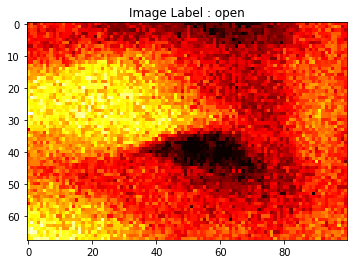

In [113]:

original_img = data[0]['crop']
plt.title("Image Label : {0}".format(label_orginal))
plt.imshow(original_img, cmap='hot')
plt.savefig('Original.png')

In [114]:
data[0]['label']

'open'

<Figure size 432x288 with 0 Axes>

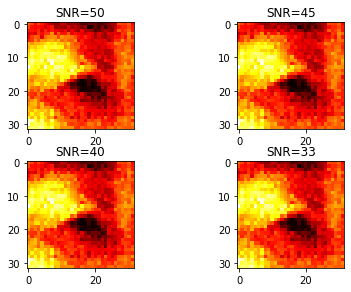

In [115]:
plt.figure(1)
fig, _ = plt.subplots(2, 2)
fig.tight_layout()

plt.subplot(221)
plt.title("SNR=50")
plt.imshow(img_50, cmap='hot')
plt.subplot(222)
plt.title("SNR=45")
plt.imshow(img_45,cmap='hot' )
plt.subplot(223)
plt.title("SNR=40")
plt.imshow(img_40, cmap='hot')
plt.subplot(224)
plt.title("SNR=33")
plt.imshow(img_33, cmap='hot')
plt.savefig('PertubatedImagesforDifferentSNR.png')
plt.show()